# Проект "Прогнозирование заказов такси"

Дата: 25 июля 2023
Исполнитель: Троицкий Илья
Проект выполнен в рамках курса Datascience Bootcamp

### Описание
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание" data-toc-modified-id="Описание-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Описание</a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Ridge" data-toc-modified-id="Ridge-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Ridge</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from catboost import CatBoostRegressor, Pool

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit


from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Настройки
pd.options.mode.chained_assignment = None
matplotlib.rc('figure', figsize=(10, 5))
sns.set_palette("pastel")

In [3]:
def make_period_features(data):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

def make_prev_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

def rmse(target, predictions):
    return np.sqrt(mean_squared_error(target, predictions))

rmse_scorer = make_scorer(rmse)    

## Подготовка

In [4]:
try:
   data = pd.read_csv('datasets/taxi.csv')
except:
   data = pd.read_csv('/datasets/taxi.csv')

In [5]:
data.info()
display(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
print(data['datetime'].min())
print(data['datetime'].max())

2018-03-01 00:00:00
2018-08-31 23:50:00


In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

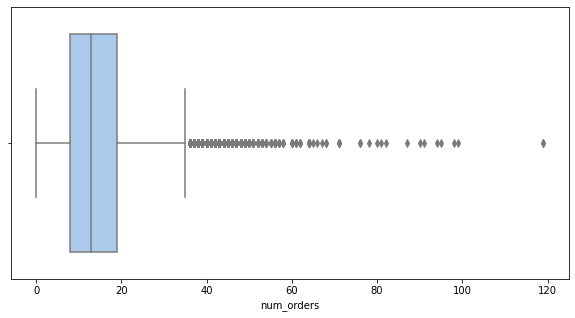

In [8]:
sns.boxplot(x=data['num_orders'])
data['num_orders'].describe()

Вывод: В датасете содержаться данные за перил с 1 марта 2018 года по 31 августа 2018 года включительно, с периодичностью в 10 минут. В 50% интервалах , количество заказов находится в промежутке 8-19 заказов. Есть выбросы.

## Анализ

Так как будем делать прогнозирование количества заказов на следующий час, то сделаем респемлирование датасета с промежутком 1 час.

In [9]:
data = data.resample('1H').sum()
print(data.shape)

(4416, 1)


<AxesSubplot:xlabel='datetime'>

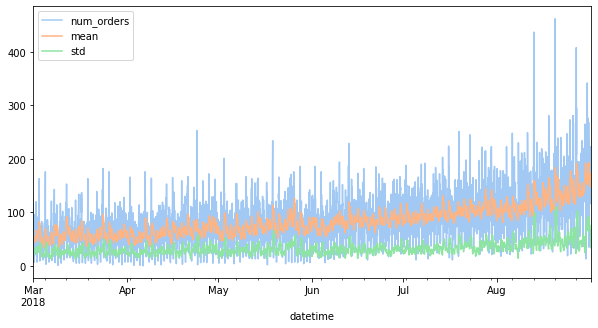

In [10]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot() 

Вывод: Количество заказов со времением растет

In [11]:
data = data.drop(['mean', 'std'], axis=1)

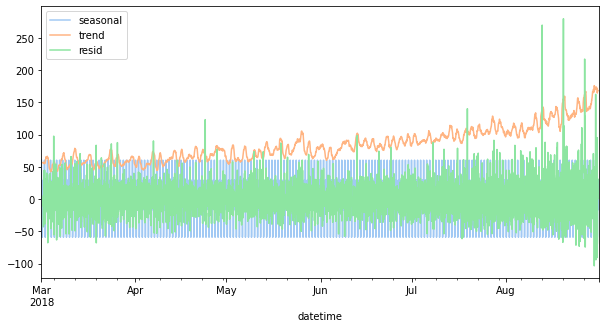

In [12]:
decomposed = seasonal_decompose(data)

ax = decomposed.seasonal.plot()
decomposed.trend.plot(ax=ax) 
decomposed.resid.plot(ax=ax)
ax.legend()
plt.show()

<AxesSubplot:xlabel='datetime'>

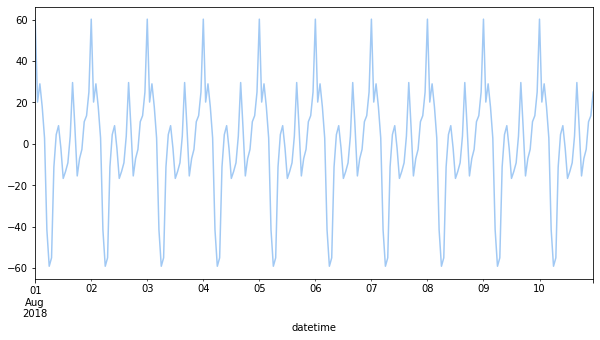

In [13]:
seasonal_decompose(data).seasonal['2018-08-01':'2018-08-10'].plot()

Вывод: Есть растущий тренд количества заказов, есть сезонность с циклов в сутки

In [14]:
make_period_features(data)
data = data.dropna()
display(data.head())

,num_orders,month,day,dayofweek,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4


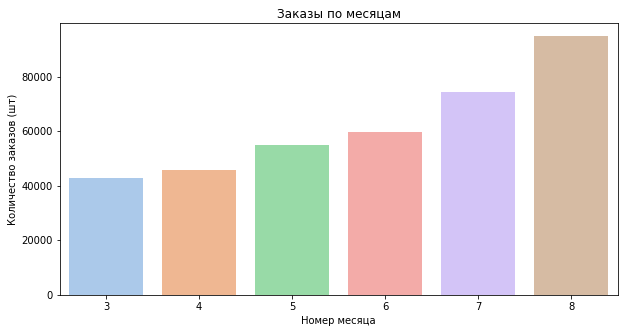

In [15]:
temp_data =  data[['month','num_orders']].groupby(by='month').sum()
ax = sns.barplot(x=temp_data.index, y=temp_data['num_orders'])
ax.set(xlabel='Номер месяца', ylabel='Количество заказов (шт)', title='Заказы по месяцам')
plt.show()

Наблюдаем тренд на увеличение заказов месяц к месяцу

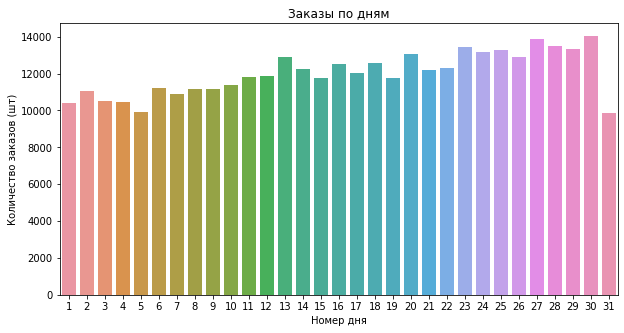

In [16]:
temp_data =  data[['day','num_orders']].groupby(by='day').sum()
ax = sns.barplot(x=temp_data.index, y=temp_data['num_orders'])
ax.set(xlabel='Номер дня', ylabel='Количество заказов (шт)', title='Заказы по дням')
plt.show()

В разрезе дней, отсутствуют тренды и сезонность. Уменьшение количества заказов 31 числа связано с тем, что 31 число есть только в половине месяцев.

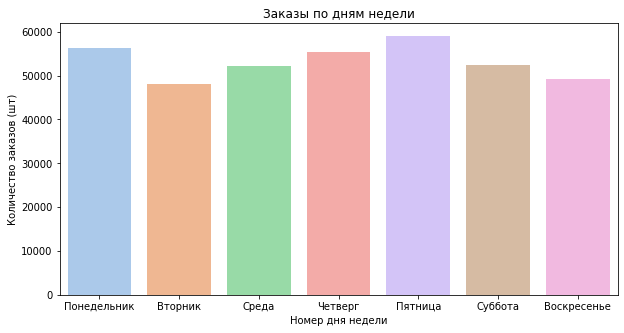

In [17]:
temp_data =  data[['dayofweek','num_orders']].groupby(by='dayofweek').sum()
ax = sns.barplot(x=temp_data.index, y=temp_data['num_orders'])
ax.set(xlabel='Номер дня недели', ylabel='Количество заказов (шт)', title='Заказы по дням недели')
ax.set_xticklabels(['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресенье'])
plt.show()

Слабовыраженный восходящий тренд со вторника по пятницу, и убывающие с пятниы по воскресенье

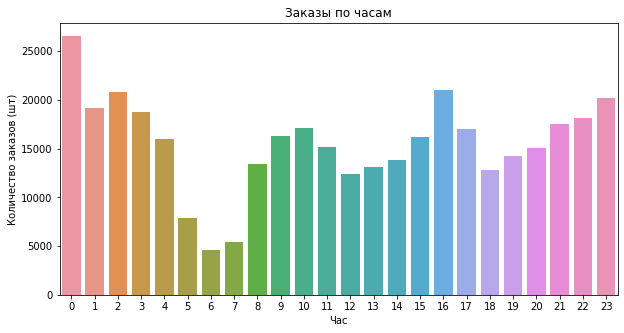

In [18]:
temp_data =  data[['hour','num_orders']].groupby(by='hour').sum()
ax = sns.barplot(x=temp_data.index, y=temp_data['num_orders'])
ax.set(xlabel='Час', ylabel='Количество заказов (шт)', title='Заказы по часам')
plt.show()

Есть снижающийся тренд после полуночи и растущий после 6 часов утра

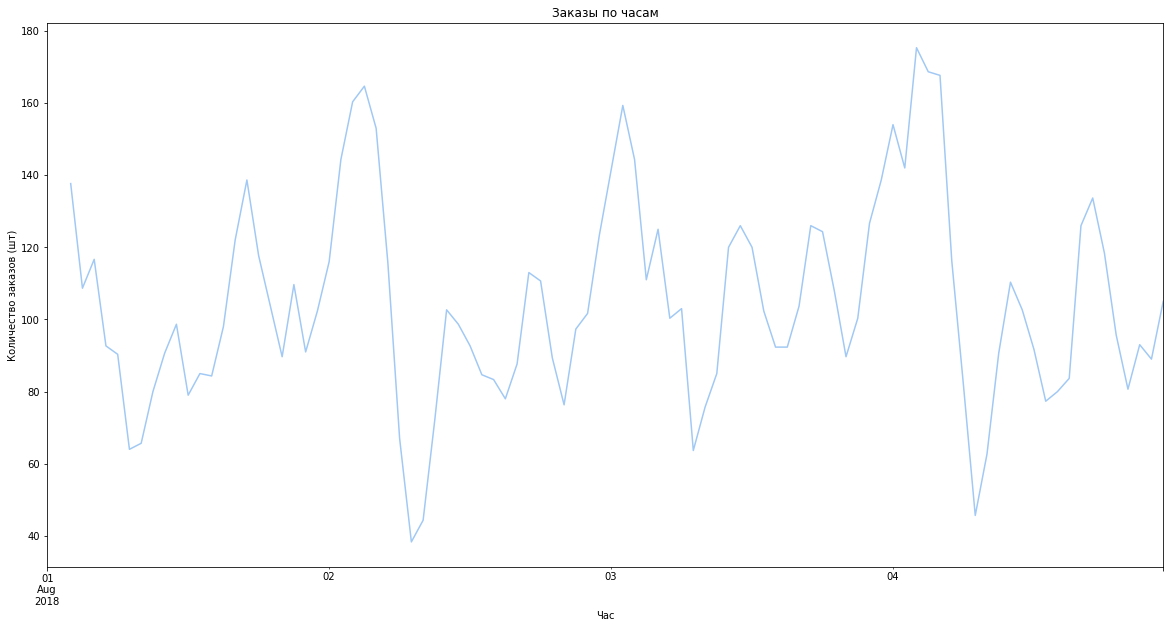

In [19]:
#data['2018-08-01':'2018-08-04'][['hour','num_orders']].rolling(3).mean().plot()
temp_data =  data['2018-08-01':'2018-08-04'][['hour', 'num_orders']].rolling(3).mean()

ax = temp_data['num_orders'].plot( figsize=(20,10))
ax.set(xlabel='Час', ylabel='Количество заказов (шт)', title='Заказы по часам')
plt.show()

Наблюдается сезонность с пиков в полночь и дном в районе 6 часов утра.

Вывод: Анализ данныз показал, что количество заказов месяц к месяцу растет. Каких то треднов в завимисоти от дня месяца нет, есть сезонностьт по дням недели с пиком в пятницу. Так же наблюдается сезонность в распределении по часу в сутках, в полночть максимальное количество заказов, в 6 утра - минимальное.

## Обучение

Так как данные у нас только за несколько месяцев, а зависимости от дня месяца мы не наблюдаем, удалим лишние признаки.

In [20]:
data = data.drop(['month', 'day'], axis=1) 

In [21]:
MAX_LAG = 24
ROLLING_MEAN_SIZE = 10
#make_prev_features(data, MAX_LAG, ROLLING_MEAN_SIZE)
#data = data.dropna()

In [22]:
def split_data(data):
    X = data.drop('num_orders', axis=1)
    y = data['num_orders']
    return train_test_split(X, y, shuffle=False, test_size=0.1, random_state=31337)

#### Линейная регрессия

In [23]:
 def train_lr_model(data):
    x_train, x_test, y_train, y_test = split_data(data)

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat_ohe', OneHotEncoder(), ['dayofweek', 'hour']),
            ('num', StandardScaler(), make_column_selector(dtype_include=np.number))
        ])
    lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor' , LinearRegression())])

    lr_model.fit(x_train,y_train)
 
    time_split = TimeSeriesSplit(n_splits=5)
    
    scores = cross_val_score(lr_model, x_train, y_train, cv=time_split.split(x_train), scoring=rmse_scorer, n_jobs=5)

    return lr_model, scores.mean()

In [ ]:
%%time

best_score = 100
best_ml = 1
best_rms = 1

for ml in range(1,MAX_LAG):
    for rms in range(1,ROLLING_MEAN_SIZE):
        
        current_data = data.copy()
        make_prev_features(current_data, ml, rms)
        current_data = current_data.dropna()

        lr_model, score = train_lr_model(current_data)

        if score < best_score:
            best_score = score
            best_model = lr_model
            best_ml = ml
            best_rms = rms

lr_model = best_model
print(f'max lag: {best_ml} rms: {best_rms} score: {best_score}')

In [ ]:
make_prev_features(data, best_ml, best_rms)
data = data.dropna()
x_train, x_test, y_train, y_test = split_data(data)


#### Ridge

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', OneHotEncoder(), ['dayofweek', 'hour']),
        ('num', StandardScaler(), make_column_selector(dtype_include=np.number))
    ])
ridge_model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor' , Ridge())])

ridge_model.fit(x_train,y_train)

time_split = TimeSeriesSplit(n_splits=5)
    
scores = cross_val_score(ridge_model, x_train, y_train, cv=time_split.split(x_train), scoring=rmse_scorer)

print("Ridge RMSE:", scores.mean())

#### Catboost

In [ ]:
%%time 

cb_model = CatBoostRegressor(random_seed=31337,
                          iterations=50,
                          learning_rate=1,
                          depth=2,
                          custom_metric='RMSE',
                          cat_features=['dayofweek', 'hour'],
                          )

param_grid = {
    'num_leaves': [31, 127],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01]
}

grid_search_result = cb_model.grid_search(param_grid,
            X=x_train,
            y=y_train,
            cv=time_split.split(x_train),
            partition_random_seed=31337,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=None,
            train_size=0.8,
            verbose=True,
            plot=False)


print('RMSE CatBoost:', cb_model.best_score_)


Линейная регрессия показывает чуть худший результат, чем Catboost. Перебирая параметры MAX_LAG и ROLLING_MEAN_SIZE, наилучших результатов удалось достич при значениях 8 и 9 соответственно. 

## Тестирование

In [ ]:
print('RMSE на тестовых данных')
print("LogisticRegression RMSE:", rmse(y_test, lr_model.predict(x_test)))
print("Ridge RMSE:", rmse(y_test, ridge_model.predict(x_test)))
print("CatBoost RMSE:", rmse(y_test, cb_model.predict(x_test)))

In [ ]:
y_pred = pd.Series(lr_model.predict(x_test), index=y_test.index)

plt.figure(figsize=(25, 10), dpi=80)
plt.title('Сравнение тестовых данных и предсказаний')
plt.plot(y_test)
plt.plot(y_pred)

plt.show()

In [ ]:
plt.figure(figsize=(25, 10), dpi=80)
plt.title('Сравнение тестовых данных и предсказаний за 5 дней')
plt.plot(y_test['2018-08-14':'2018-08-17'])
plt.plot(y_pred['2018-08-14':'2018-08-17'])
plt.show()

## Вывод
В предоставленных данных содержалась инфмормация о количестве заказов такси с периодичностью в 10 минут за отрезок с 1 марта по 31 августа 2018 года. Учитывая, что поставлена задача - прогнозировать количество заказов на ближайший час, данные были агрегированы с перидочностью в час. Перед обучение модели, в набор данных были добавлены предыдущии значения показателя и плавающее среднее. Обучили две модели с перебором параметров. (Линейную регрессию, Ridge и CatBoost) и на тесовых данных лучшеую оценку показала линейная регрессия с оценкой RMSE ~44, что удовлетворяет условию задачи в 48.